==============================================================================================

&lsaquo; GPMIntro.ipynb  &rsaquo;
Copyright (C) &lsaquo; 2017 &rsaquo;  &lsaquo; Anna Scaife - anna.scaife@manchester.ac.uk &rsaquo;

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

==============================================================================================




[AMS - 170402]  Notebook created for SKA-SA Newton Big Data Summer School, Cape Town , April 2017.
--

This notebook uses GPM to predict a signal.  It recreates some of the plots from Roberts et al. 2013 (http://www.robots.ox.ac.uk/~sjrob/Pubs/Phil.%20Trans.%20R.%20Soc.%20A-2013-Roberts-.pdf). It is a teaching resource and is accompanied by  the lecture "Can you Predict the Future..?".

All Python libraries used in this example can be installed using **pip**.

---------------------------------------------------------------------------------------------

To start let's specify that we want our figures to appear embedded in the notebook:

In [12]:
%matplotlib inline

Then let's import all the libraries we need...

In [13]:
import numpy as np
import pylab as pl

Make the covariance kernel a squared-exponential,

$k(x_1,x_2) = h^2 \exp{ \left( \frac{-(x_1 - x_2)^2}{\lambda^2} \right)}$,

just like Eq. 3.11 in Roberts et al. (2012).

http://www.robots.ox.ac.uk/~sjrob/Pubs/Phil.%20Trans.%20R.%20Soc.%20A-2013-Roberts-.pdf

In [14]:
def cov_kernel(x1,x2,h,lam):
    """
    Squared-Exponential covariance kernel
    """
    k12 = h**2*np.exp(-1.*(x1 - x2)**2/lam**2)
    
    return k12

We can use this kernel to calculate  the value of each element in our covariance matrix:

$\mathbf{K(x,x)} = \left(
\begin{array}{cccc}
k(x_1,x_1) & k(x_1,x_2) & ... & k(x_1,x_n) \\
k(x_2,x_1) & k(x_2,x_2) & ... & k(x_2,x_n) \\
\vdots & \vdots & \vdots & \vdots \\
k(x_n,x_1) & k(x_n,x_2) & ... & k(x_n,x_n) 
\end{array}
\right).$

We can then populate a covariance matrix, $K(\mathbf{x},\mathbf{x})$, for our data:

In [8]:
def make_K(x, h, lam):
    
    """
    Make covariance matrix from covariance kernel
    """
    
    # for a data array of length x, make a covariance matrix x*x:
    K = np.zeros((len(x),len(x)))
    
    for i in range(0,len(x)):
        for j in range(0,len(x)):
            
            # calculate value of K for each separation:
            K[i,j] = cov_kernel(x[i],x[j],h,lam)
            
    return K

Using this kernel we can then recreate Fig. 5 from Roberts et al. (2012).

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: covariance is not positive-semidefinite.


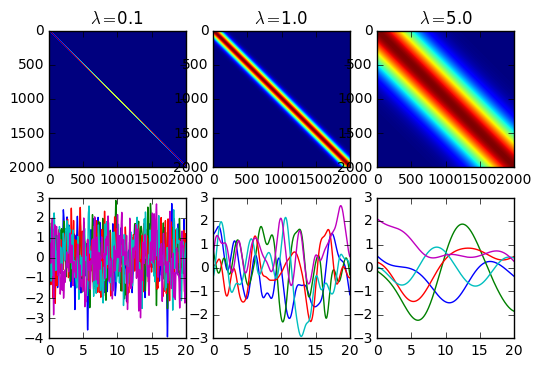

In [15]:
# make an array of 200 evenly spaced positions between 0 and 20:
x1 = np.arange(0, 20.,0.01)
    
for i in range(0,3):
    
    h = 1.0
    
    if (i==0): lam = 0.1
    if (i==1): lam = 1.0
    if (i==2): lam = 5.0
        
    # make a covariance matrix:
    K = make_K(x1,h,lam)
    
    # five realisations:
    for j in range(0,5):
        
        # draw samples from a co-variate Gaussian distribution, N(0,K):
        y1 = np.random.multivariate_normal(np.zeros(len(x1)),K)
    
        tmp2 = '23'+str(i+3+1)
        pl.subplot(int(tmp2))
        pl.plot(x1,y1)
        
        
    tmp1 = '23'+str(i+1)
    pl.subplot(int(tmp1))
    pl.imshow(K)
    pl.title(r"$\lambda = $"+str(lam))
    
    
pl.show()

If we then take the final realization, which has $\lambda = 5$, and select 5 points from it randomly we can calculate the posterior mean and variance at every point based on those five input data. 

The mean and variance are given by Eq. 3.8 & 3.9 in Roberts et al. (2012) or Eq. 2.25 & 2.26 in Rasmussen & Williams.

First let's select our  **training data points** and our **test data points**:

In [43]:
# set number of training points
nx_training = 5

# randomly select the training points:
tmp = np.random.uniform(low=0.0, high=2000.0, size=nx_training)
tmp = tmp.astype(int)

condition = np.zeros_like(x1)
for i in tmp: condition[i] = 1.0
    
y_train = y1[np.where(condition==1.0)]
x_train = x1[np.where(condition==1.0)]
y_test = y1[np.where(condition==0.0)]
x_test = x1[np.where(condition==0.0)]

We then use our **training data points** to define a covariance matrix:

In [44]:
# define the covariance matrix:
K = make_K(x_train,h,lam)

# take the inverse:
iK = np.linalg.inv(K)

For each of our **test data points** we can then make a prediction of the value at $x_{\ast}$ and the uncertainly (standard deviation):

In [45]:
mu=[];sig=[]
for xx in x_test:

    # find the 1d covariance matrix:
    K_x = cov_kernel(xx, x_train, h, lam)
    
    # find the kernel for (x,x):
    k_xx = cov_kernel(xx, xx, h, lam)
    
    # calculate the posterior mean and variance:
    mu_xx = np.dot(K_x.T,np.dot(iK,y_train))
    sig_xx = k_xx - np.dot(K_x.T,np.dot(iK,K_x))
    
    mu.append(mu_xx)
    sig.append(np.sqrt(np.abs(sig_xx))) # note sqrt to get stdev from variance


Let's plot this up:

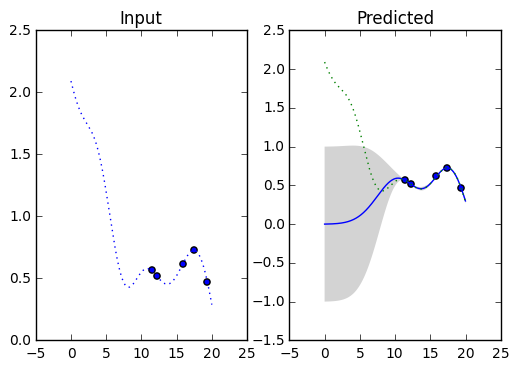

In [46]:
# mu and sig are currently lists - turn them into numpy arrays:
mu=np.array(mu);sig=np.array(sig)

# make some plots:

# left-hand plot
ax = pl.subplot(121)
pl.scatter(x_train,y_train)  # plot the training points
pl.plot(x1,y1,ls=':')        # plot the original data they were drawn from
pl.title("Input")

# right-hand plot
ax = pl.subplot(122)
pl.plot(x_test,mu,ls='-')     # plot the predicted values
pl.plot(x_test,y_test,ls=':') # plot the original values


# shade in the area inside a one standard deviation bound:
ax.fill_between(x_test,mu-sig,mu+sig,facecolor='lightgrey', lw=0, interpolate=True)
pl.title("Predicted")

pl.scatter(x_train,y_train)  # plot the training points

# display the plot:
pl.show()

[Note: Depending on  the selection of training points you might want to specify some axis ranges for these plots]

--END--